In [ ]:
import numpy as np, pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt

import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from datasets import load_dataset
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 1) Association Rule Generation from Transaction Data
    # Sources:
        # https://www.geeksforgeeks.org/numpy-ndarray-flatten-function-python/
        # https://pandas.pydata.org/docs/reference/api/pandas.isna.html#pandas.isna

# (a) & (b): download and read in csv file
df = pd.read_csv("Grocery_Items_10.csv")

# (c): Find unique items, # of records, and most popular item
df_array = df.values.flatten()   # flattens data to 1d array
df_array = df_array[~pd.isna(df_array)] # remove nan values
unique = len(np.unique(df_array))
print(f"Number of Unique Items: {unique}")

num_records = len(df)
print(f"Number of records: {num_records}")

item_counts = pd.Series(df_array).value_counts()
most_frequent = item_counts.index[0]
most_frequent_count = item_counts.iloc[0]
print(f"Most Popular: {most_frequent} with {most_frequent_count} transactions")

Number of Unique Items: 167
Number of records: 8000
Most Popular: whole milk with 1328 transactions


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# (d): Use minsup=0.01 and minconf=0.08, what are the association rules
#      you can extract from your dataset?

# drop nan values in each row and put everything in a list of lists
data = df.apply(lambda row: row.dropna().astype(str).tolist(),axis=1).tolist()

te = TransactionEncoder()
te_ary = te.fit(data).transform(data)
dataframe = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(dataframe, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric="confidence", min_threshold=0.08)
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(other vegetables),(rolls/buns),0.119750,0.111625,0.010750,0.089770,0.804214,1.0,-0.002617,0.975990,-0.216651,0.048725,-0.024601,0.093037
1,(rolls/buns),(other vegetables),0.111625,0.119750,0.010750,0.096305,0.804214,1.0,-0.002617,0.974056,-0.215095,0.048725,-0.026635,0.093037
2,(other vegetables),(whole milk),0.119750,0.157500,0.016000,0.133612,0.848328,1.0,-0.002861,0.972428,-0.168822,0.061244,-0.028354,0.117599
3,(whole milk),(other vegetables),0.157500,0.119750,0.016000,0.101587,0.848328,1.0,-0.002861,0.979784,-0.175062,0.061244,-0.020634,0.117599
4,(whole milk),(rolls/buns),0.157500,0.111625,0.014375,0.091270,0.817647,1.0,-0.003206,0.977600,-0.209308,0.056428,-0.022913,0.110025
5,(rolls/buns),(whole milk),0.111625,0.157500,0.014375,0.128779,0.817647,1.0,-0.003206,0.967034,-0.200668,0.056428,-0.034090,0.110025
6,(soda),(whole milk),0.098625,0.157500,0.012125,0.122940,0.780574,1.0,-0.003408,0.960596,-0.237727,0.049693,-0.041020,0.099962
7,(yogurt),(whole milk),0.088750,0.157500,0.012125,0.136620,0.867427,1.0,-0.001853,0.975816,-0.143630,0.051789,-0.024784,0.106802


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


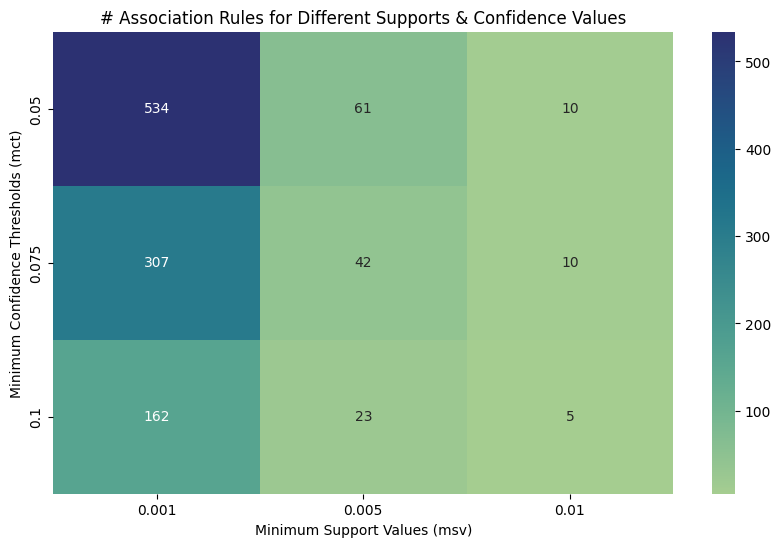

In [ ]:
# (e): Use msv=0.001,0.005,0.01 and mct=0.05,0.075,0.1. For each pair
#      (msv, mct), find the number of association rules extracted from the
#      dataset. Construct a heatmap using Seaborn data visualization library
#      to show the count results such that x-axis is msv and y-axis is mct.

msv = [0.001, 0.005, 0.01]
mct = [0.05, 0.075, 0.1]
counts = pd.DataFrame(index=mct, columns=msv)

for s in msv:
    for c in mct:
        frequent_itemsets = apriori(dataframe, min_support=s, use_colnames=True)
        rules = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric="confidence", min_threshold=c)
        counts.loc[c, s] = len(rules)

counts = counts.astype(int)

plt.figure(figsize=(10,6))
sns.heatmap(counts, annot=True, fmt="d",cmap="crest")
plt.title("# Association Rules for Different Supports & Confidence Values")
plt.xlabel("Minimum Support Values (msv)")
plt.ylabel("Minimum Confidence Thresholds (mct)")
plt.show()

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.2600 - loss: 1.3741 - val_accuracy: 0.3286 - val_loss: 1.2710
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3157 - loss: 1.2788 - val_accuracy: 0.3500 - val_loss: 1.2265
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3303 - loss: 1.2290 - val_accuracy: 0.3857 - val_loss: 1.1736
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4316 - loss: 1.1495 - val_accuracy: 0.4786 - val_loss: 1.0334
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5219 - loss: 1.0355 - val_accuracy: 0.5071 - val_loss: 0.9829
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5751 - loss: 0.9754 - val_accuracy: 0.5571 - val_loss: 0.9513
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5644 - loss: 0.9807 - val_accuracy: 0.5786 - val_loss: 0.9464
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6023 - loss: 0.9000 - val_accuracy: 0.5429 - v

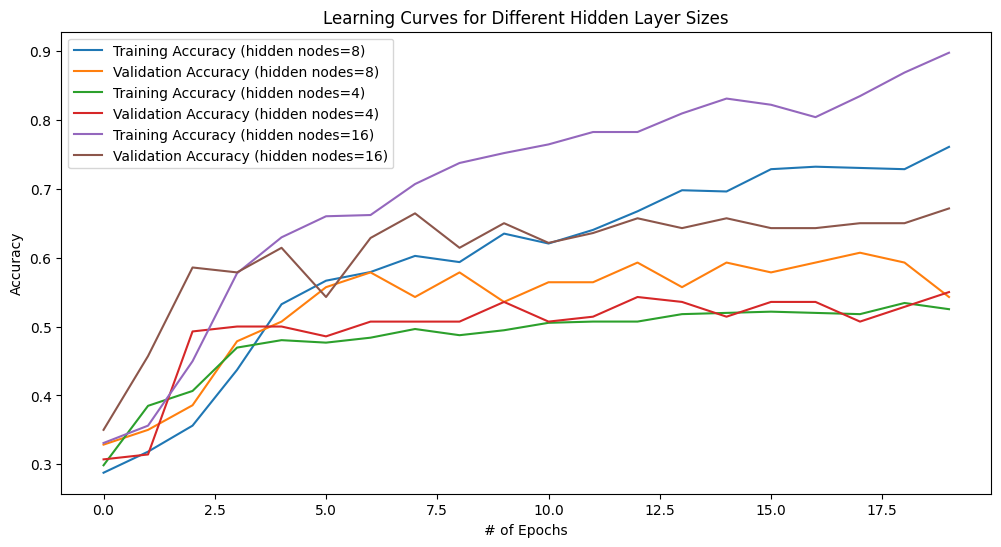

In [ ]:
# 2) Image Classification Using CNN
    # Rowan ID: 916357697 <- last digit is 7, so complete part (c)

data = './Processed_Data'
classes = ['n02085782-Japanese_spaniel',
           'n02093428-American_Staffordshire_terrier',
           'n02105056-groenendael',
           'n02113186-Cardigan']

# Function to retrieve all data and store properly
def preprocess(data, classes):
    images = []
    labels = []
    for index, class_name in enumerate(classes):
        class_dir = os.path.join(data, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path)
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image_array)
            labels.append(index)
    images = np.array(images)/255.0
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(classes))
    return images, labels

# Load and split data into training and validation sets
X, y = preprocess(data, classes)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to create CNN using different hidden layer nodes for part (c)
def create_model(hidden_nodes):
    model = models.Sequential()

    # First convolutional layer - 8 3x3 filters
    model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer - 4 3x3 filters
    model.add(layers.Conv2D(4, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten
    model.add(layers.Flatten())

    # Hidden layer
    model.add(layers.Dense(hidden_nodes, activation='relu'))

    # Output layer
    model.add(layers.Dense(4, activation='softmax'))

    # Compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# (c) setting hidden node values
hidden_node_values = [8, 4, 16]
history = {}

for nodes in hidden_node_values:
    model = create_model(nodes)
    history[nodes] = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# plotting one graph with all learning curves for each hidden layer node value
plt.figure(figsize=(12, 6))
for nodes in hidden_node_values:
    plt.plot(history[nodes].history['accuracy'], label=f'Training Accuracy (hidden nodes={nodes})')
    plt.plot(history[nodes].history['val_accuracy'], label=f'Validation Accuracy (hidden nodes={nodes})')

plt.title('Learning Curves for Different Hidden Layer Sizes')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Describe and discuss what you observe by comparing the performance of the first model
# and the other two models you constructed in (c). Comment on whether the models are
# overfit, underfit, or just right.
    # The accuracies of the hidden layer with 4 nodes is just right, while the others,
    # with nodes 8 and 16, are both kind of overfitting, as their training accuracy is
    # much higher that validation accuracy. The performance of the models does seem to be
    # better when the nodes are of higher values, as the highest accuracy occurs where the
    # hidden layer has 16 nodes.

In [ ]:
# 3) Text Classification by Fine-Tuning LLM Model

# Load all data
dataset = load_dataset('json', data_files={'train': '10_train.json',
                                           'test': '10_test.json',
                                           'validation': '10_validation.json'})

# Make labels and map labels to integers
labels = [label for label in dataset['train'].features.keys() if label not in ['ID', 'Tweet']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

# Preprocessing data using AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
    # take a batch of texts
    text = examples["Tweet"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding

encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

# Format data to PyTorch tensors
encoded_dataset.set_format("torch")

# Defining model to include pretrained base
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

# Training model using Trainer API
args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to=[],  # disabling wandb api key
    logging_first_step=True   # log on the first step
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Starting training
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-493bf7d63169>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.762300,0.367059,0.615385,0.735676,0.207500
2,0.399500,0.329299,0.677677,0.773824,0.262500
3,0.291700,0.323112,0.667445,0.765118,0.252500
4,0.243000,0.321138,0.678551,0.773088,0.257500
5,0.243000,0.322958,0.687151,0.781765,0.270000


TrainOutput(global_step=1875, training_loss=0.29290601590474447, metrics={'train_runtime': 555.6715, 'train_samples_per_second': 26.994, 'train_steps_per_second': 3.374, 'total_flos': 986746187520000.0, 'train_loss': 0.29290601590474447, 'epoch': 5.0})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


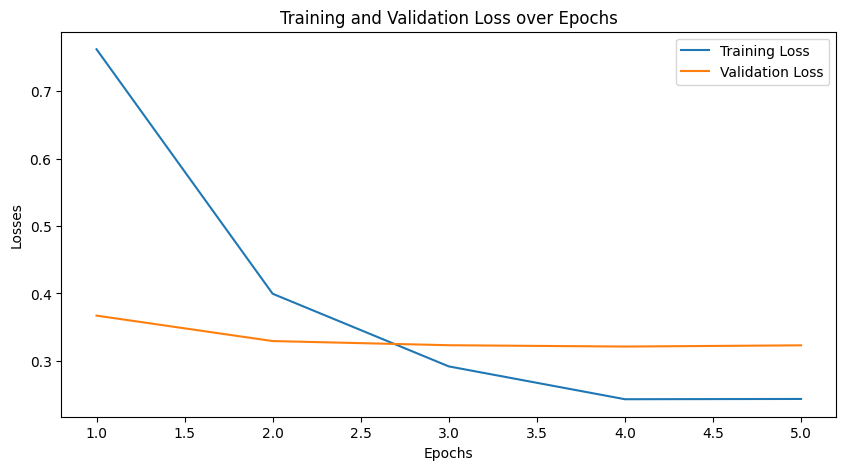

In [ ]:
# 1. Plotting the Learning Curves
# Retrieve training and validation losses from the `trainer.state.log_history`
train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
train_losses.append(0.2434)   # to account for the duplicate value that gets ignored in epoch 5
val_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

In [ ]:
# Computing test accuracy - all labels must match
test = trainer.predict(encoded_dataset["test"])
y_true = test.label_ids
pred = torch.sigmoid(torch.Tensor(test.predictions)) >= 0.5
y_pred = pred.numpy()
accuracy = np.mean([np.array_equal(pred, true) for pred, true in zip(y_pred, y_true)])
print(f"Test Accuracy: {accuracy}")

# Test accuracy where a predication is correct as long as one label matches
accuracy = np.mean([np.any(pred == true) for pred, true in zip(y_pred, y_true)])
print(f"Test Accuracy (At least one label matches): {accuracy}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test Accuracy: 0.29933333333333334
Test Accuracy (At least one label matches): 1.0
